# Importing necessary libraries

In [34]:
!pip install tensorflow-addons Pillow

In [35]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

import torch
import torchvision.models as models
from torchvision import transforms

from PIL import Image

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# Loading the dataset
1. Add the training dataset's zip file to your google drive.
2. Mount the google drive to the colab notebook by running the first code setion.
3. Unzip the file to the local environment by running the second code section. (Set the path to the dataset accordingly)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/archive.zip

# Preprocessing the data

Preprocess the training data to convert the images and labels into Numpy arrays for CNN to recognize.

In [16]:
# Getting paths to training and testing images
train_fol = '/content/Human Action Recognition/train'
test_fol = '/content/Human Action Recognition/test'

# Getting paths to csv files
train_csv = '/content/Human Action Recognition/Training_set.csv'
test_csv = '/content/Human Action Recognition/Testing_set.csv'

# Store the csv file as a Pandas dataframe
train_data = pd.read_csv(train_csv)

# Get the columns of the dataframe
train_filenames = train_data['filename']
train_labels = train_data['label']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
# Getting the paths to test images
test_data = pd.read_csv(test_csv)
test_filenames = test_data['filename']
test_paths = []
for i in range(len(test_data)):
  test_paths.append(test_fol + '/' + test_filenames[i])

In [19]:
def img_splitter(img_path):
  img = Image.open(img_path) # Get the image
  # Split the image into its red, green and blue components and store it in an array
  return np.asarray(img.resize((160, 160))) # Convert and store the image

In [20]:
# Store the preprocessed arrays of images
converted_images = []

# Go through each image and store the corresponding array
for i in range(len(train_data)):
  img = Image.open(os.path.join(train_fol + "/" + train_filenames[i])) # Get the image
  # Split the image into its red, green and blue components and store it in an array
  converted_images.append(np.asarray(img.resize((160, 160)))) # Convert and store the image

# Convert the array into a Numpy array
x_train = np.asarray(converted_images)

In [21]:
# Convert the labels column in the dataframe to an array with 15 indices for each label
y_train = to_categorical(np.asarray(train_labels.factorize()[0]))
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# CNN

## Making model

In [22]:
efficientnet_model = Sequential()

model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False


efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

258076736/258076736 [==============================] - 7s 0us/step


In [23]:
efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [24]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 65416614 (249.54 MB)
Trainable params: 1318927 (5.03 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [25]:
history = efficientnet_model.fit(x_train,y_train,epochs=40)

Epoch 1/40
394/394 [==============================] - 101s 186ms/step - loss: 1.2665 - accuracy: 0.5998
Epoch 2/40
394/394 [==============================] - 74s 188ms/step - loss: 0.8802 - accuracy: 0.7142
Epoch 3/40
394/394 [==============================] - 75s 191ms/step - loss: 0.6566 - accuracy: 0.7852
Epoch 4/40
394/394 [==============================] - 76s 193ms/step - loss: 0.4731 - accuracy: 0.8475
Epoch 5/40
394/394 [==============================] - 76s 193ms/step - loss: 0.3412 - accuracy: 0.8888
Epoch 6/40
394/394 [==============================] - 76s 193ms/step - loss: 0.2379 - accuracy: 0.9274
Epoch 7/40
394/394 [==============================] - 76s 194ms/step - loss: 0.1715 - accuracy: 0.9491
Epoch 8/40
394/394 [==============================] - 76s 194ms/step - loss: 0.1316 - accuracy: 0.9615
Epoch 9/40
394/394 [==============================] - 77s 194ms/step - loss: 0.1198 - accuracy: 0.9637
Epoch 10/40
394/394 [==============================] - 76s 194ms/step - 

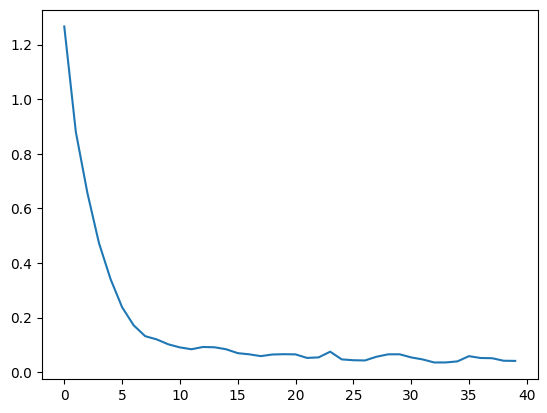

In [26]:
losses = history.history["loss"]
plt.plot(losses)

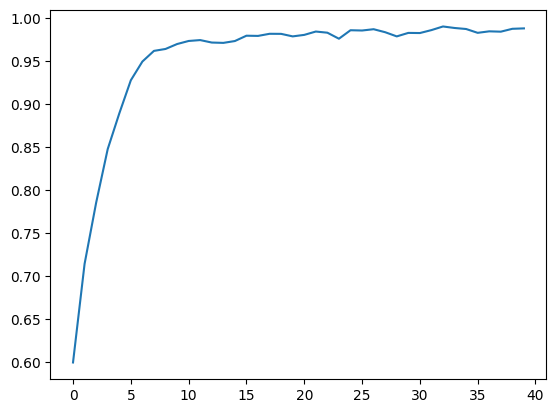

In [27]:
acc = history.history['accuracy']
plt.plot(acc)

## Model predictions

In [36]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [37]:
def test_predict(test_image):
    result = efficientnet_model.predict(np.asarray([read_img(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

1/1 [==============================] - 0s 44ms/step
probability: 96.38445377349854%
Predicted class :  1


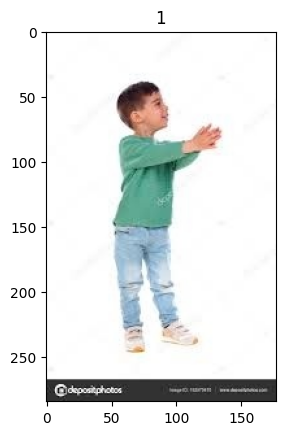

In [38]:
test_predict('/content/Human Action Recognition/test/Image_1001.jpg')

1/1 [==============================] - 0s 76ms/step
probability: 99.99896287918091%
Predicted class :  4


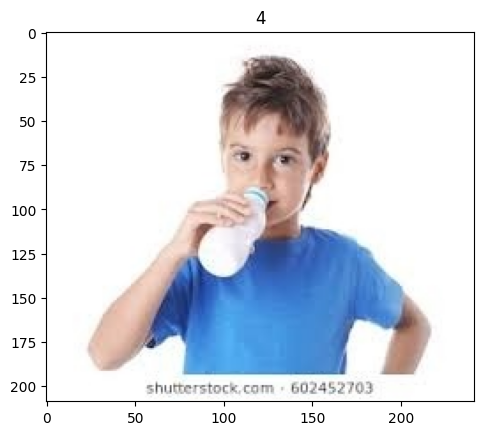

In [39]:
test_predict('/content/Human Action Recognition/test/Image_101.jpg')

# Using Pretrained Models

## 1. ResNet101

In [ ]:
# Intializing a Sequential model
resnet101_model = Sequential()

# Getting a pretrained ResNet101 model
pretrained_resnet101_model = tf.keras.applications.ResNet101(
  include_top=False,
  input_shape=(160, 160, 3),
  pooling='avg',
  classes=15, # Initialized the number of classes in the dataset
  weights='imagenet'
)

# Fixing the weights of the pretrained model to avoid retraining
for layer in pretrained_resnet101_model.layers:
  layer.trainable = False

# Adding the pretrained model and additional layers to the Sequential model
resnet101_model.add(pretrained_resnet101_model)
resnet101_model.add(Flatten())
resnet101_model.add(Dense(512, activation='relu'))
resnet101_model.add(Dense(15, activation='softmax')) # Predicts one of 15 labels

In [ ]:
# Compiling the model
resnet101_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet101_model.summary()

In [ ]:
# Training the model
history = resnet101_model.fit(x_train, y_train, epochs=60)

In [ ]:
test_img = Image.open(test_paths[9])
a = np.asarray(test_img.resize((160, 160)))
result = resnet101_model.predict(np.asarray([a]))
item_index = np.where(result==np.max(result))
print(item_index[1][0])

test_img

## 2. AlexNet

In [ ]:
# Preprocessing and transformations for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Loading AlexNet pretrained model
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.eval()  # Setting the model to evaluation mode

In [ ]:
# Function to get prediction
def get_prediction(img_path, model):
    input_image = Image.open(img_path)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Using the model to get prediction
    with torch.no_grad():
        output = model(input_batch)
    return output[0]

In [ ]:
# Loop through all image files in the test directory
for filename in test_data['filename']:
    # Construct the path to the current image file
    test_image_path = os.path.join(test_fol, filename)

    # Get prediction for the current image file
    prediction = get_prediction(test_image_path, alexnet_model)
    probabilities = torch.nn.functional.softmax(prediction, dim=0)
    print(probabilities)